# 1. SETTINGS

In [13]:
# libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from IPython.display import display
import scipy.stats

In [14]:
# pandas options
pd.set_option("display.max_columns", None)

In [15]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [16]:
# garbage collection
import gc
gc.enable()

# 2. NAIVE BENCHMARK

In [17]:
# import data
train = pd.read_csv("../data/prepared/train.csv")
test  = pd.read_csv("../data/prepared/test.csv")
data = pd.concat([train, test[["Week", "CustomerIdx", "IsinIdx", "BuySell", "CustomerInterest"]]])

In [18]:
# check all datasets
display(test.head(3))
print("Test data:", test.shape)
print("------------------------------")
display(train.head(3))
print("Train data:", train.shape)
print("------------------------------")
display(data.head(3))
print("Full data:", data.shape)

,PredictionIdx,DateKey,CustomerIdx,IsinIdx,BuySell,CustomerInterest,Week
0,a1e0d80784,20180423,1856,13323,Buy,NaN,122.0
1,c2cc6cc2a8,20180423,1856,9230,Buy,NaN,122.0
2,a8e94f6344,20180423,1780,9157,Buy,NaN,122.0


Test data: (484758, 7)
------------------------------


,Week,CustomerIdx,IsinIdx,BuySell,CustomerInterest
0,1.0,10,312,Buy,0
1,1.0,10,316,Sell,0
2,1.0,10,2686,Sell,0


Train data: (6262730, 5)
------------------------------


,Week,CustomerIdx,IsinIdx,BuySell,CustomerInterest
0,1.0,10,312,Buy,0.0
1,1.0,10,316,Sell,0.0
2,1.0,10,2686,Sell,0.0


Full data: (6747488, 5)


In [19]:
# sort data
data = data.sort_values(["CustomerIdx", "Week", "IsinIdx", "BuySell"])

In [20]:
# remove first year
data = data[(data.Week > 60)]

In [21]:
data.head()

,Week,CustomerIdx,IsinIdx,BuySell,CustomerInterest
3008480,61.0,0,22294,Sell,1.0
3204568,63.0,0,22705,Buy,1.0
3260089,66.0,0,25326,Sell,1.0
3260090,66.0,0,25396,Buy,1.0
3533811,70.0,0,25081,Sell,1.0


In [22]:
# add missing weeks
data = data.groupby(["CustomerIdx", "Week", "IsinIdx", "BuySell"]).CustomerInterest.mean().unstack("Week").stack("Week", dropna = False)
data = data.reset_index()
data.columns = ['CustomerIdx', 'IsinIdx', 'BuySell', 'Week', 'CustomerInterest']

In [23]:
data.shape

(97432070, 5)

In [24]:
data = data.fillna(0)

In [25]:
data.CustomerInterest.mean()

0.009798488321145183

In [26]:
# compute lags
tmp = data.groupby(["CustomerIdx", "IsinIdx", "BuySell"], as_index = False)
for t in range(1, 33):
    print(t)
    data["lag" + str(t)] = tmp.CustomerInterest.shift(t).fillna(0)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


In [27]:
data.shape

(97432070, 37)

In [28]:
# recency
data["recency"] = 33
for t in reversed(range(1, 33)):
    data["recency"][data["lag" + str(t)] == 1] = t

In [29]:
# frequency
data["frequency"] = data.filter(like = "lag").sum(axis = 1)

In [30]:
# custsum 1
custsum = data.groupby(["CustomerIdx", "Week"], as_index = False).frequency.sum()
custsum.columns = ['CustomerIdx', 'Week', 'CustSum1']
data = data.merge(custsum, how = "left")

# custsum 2
custsum = data.groupby(["CustomerIdx", "Week", "BuySell"], as_index = False).frequency.sum()
custsum.columns = ['CustomerIdx', 'Week', 'BuySell', 'CustSum2']
data = data.merge(custsum, how = "left")

In [ ]:
# bondsum 1
bondsum = data.groupby(["IsinIdx", "Week"], as_index = False).frequency.sum()
bondsum.columns = ['IsinIdx', 'Week', 'BondSum1']
data = data.merge(bondsum, how = "left")

# bondsum 2
bondsum = data.groupby(["IsinIdx", "Week", "BuySell"], as_index = False).frequency.sum()
bondsum.columns = ['IsinIdx', 'Week', 'BuySell', 'BondSum2']
data = data.merge(bondsum, how = "left")

In [ ]:
# data partitioning
train = data[(data["Week"] >= 92)  & (data["Week"] <= 115)]
valid = data[(data["Week"] >= 116) & (data["Week"] <= 121)]
test  = test[["PredictionIdx", "CustomerIdx", "IsinIdx", "BuySell"]].merge(data[data["Week"] == 122], how = "left")

In [ ]:
### function for historical target ratio
def compute_target(data, lags):
    
    # filter lags
    feats = ["lag" + str(i) for i in range(1, lags + 1)]
    data["Last" + str(lags) + "WeeksMean"] = data[feats].mean(axis = 1)
    
    # return test data
    return data

In [ ]:
train = compute_target(train, lags = 4)
train = compute_target(train, lags = 8)
train = compute_target(train, lags = 16)
train = compute_target(train, lags = 32)

valid = compute_target(valid, lags = 4)
valid = compute_target(valid, lags = 8)
valid = compute_target(valid, lags = 16)
valid = compute_target(valid, lags = 32)

test = compute_target(test, lags = 4)
test = compute_target(test, lags = 8)
test = compute_target(test, lags = 16)
test = compute_target(test, lags = 32)

In [ ]:
# list of features
features = ["Last4WeeksMean", "Last8WeeksMean", "Last16WeeksMean", "Last32WeeksMean",
            "recency", "frequency", "CustSum1", "CustSum2", "BondSum1", "BondSum2"]
features

In [ ]:
# targets
y_train = train["CustomerInterest"]
y_valid = valid["CustomerInterest"]

In [ ]:
print(train.shape)
print(valid.shape)
print(test.shape)

In [ ]:
### PARAMETERS

# learner settings
metric   = "auc"
verbose  = 10
stopping = 50
seed = 42

# lgb settings
gbm = lgb.LGBMClassifier(n_estimators     = 1000,
                         learning_rate    = 0.005,
                         num_leaves       = 70,
                         colsample_bytree = 0.8,
                         subsample        = 0.9,
                         max_depth        = 7,
                         reg_alpha        = 0.1,
                         reg_lambda       = 0.1,
                         min_split_gain   = 0.01,
                         min_child_weight = 2,
                         random_state     = seed)

In [25]:
# train lightGBM
gbm = gbm.fit(train[features], y_train, 
              eval_set = [(train[features], y_train), (valid[features], y_valid)], 
              eval_metric = metric, 
              verbose = verbose, 
              early_stopping_rounds = stopping)
    
# save number of iterations
num_iters = gbm.best_iteration_

# predict valid and test
valid_pred_CustomerInterest = gbm.predict_proba(valid[features], num_iteration = num_iters)[:, 1]
test["CustomerInterest"]    = gbm.predict_proba(test[features],  num_iteration = num_iters)[:, 1]

Training until validation scores don't improve for 50 rounds.
[10]	valid_0's auc: 0.74093	valid_1's auc: 0.719674
[20]	valid_0's auc: 0.742152	valid_1's auc: 0.720451
[30]	valid_0's auc: 0.742629	valid_1's auc: 0.72105
[40]	valid_0's auc: 0.74281	valid_1's auc: 0.721407
[50]	valid_0's auc: 0.742772	valid_1's auc: 0.721541
[60]	valid_0's auc: 0.742814	valid_1's auc: 0.721583
[70]	valid_0's auc: 0.74291	valid_1's auc: 0.721706
[80]	valid_0's auc: 0.743145	valid_1's auc: 0.72168
[90]	valid_0's auc: 0.743195	valid_1's auc: 0.721644
[100]	valid_0's auc: 0.743537	valid_1's auc: 0.721833
[110]	valid_0's auc: 0.743618	valid_1's auc: 0.721839
[120]	valid_0's auc: 0.743631	valid_1's auc: 0.721855
[130]	valid_0's auc: 0.743672	valid_1's auc: 0.721791
[140]	valid_0's auc: 0.743714	valid_1's auc: 0.721779
Early stopping, best iteration is:
[98]	valid_0's auc: 0.743511	valid_1's auc: 0.721876


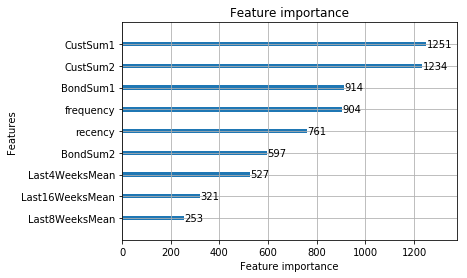

In [26]:
ax = lgb.plot_importance(gbm)
plt.show()

In [33]:
valid.CustomerInterest.mean()

0.01194030064855048

In [31]:
valid_pred_CustomerInterest.mean()

0.3107485589093092

In [32]:
test["CustomerInterest"].mean()

0.31355398190710243

In [160]:
# export CSV
subm = test[["PredictionIdx", "CustomerInterest"]]
subm.to_csv("../submissions/lgb_mean031_auc0721.csv", index = False, float_format = "%.8f")

In [20]:
#data.head().groupby(["CustomerIdx", "BuySell"], as_index = False).Week.transform(pd.Series.diff)

In [9]:
# add missing weeks
#data = data.groupby(["CustomerIdx", "Week", "IsinIdx", "BuySell"]).CustomerInterest.mean().unstack("Week").stack("Week", dropna = False)
#data = data.reset_index()
#data.columns = ['CustomerIdx', 'IsinIdx', 'BuySell', 'Week', 'CustomerInterest']

In [11]:
# compute lags
tmp = data.groupby(["CustomerIdx", "IsinIdx", "BuySell"], as_index = False)
for t in range(1, 51):
    data["lag" + str(t)] = tmp.CustomerInterest.shift(t).fillna(0)

TypeError: 'DataFrameGroupBy' object does not support item assignment

In [32]:
tmp = data[0:1000].groupby(["CustomerIdx", "IsinIdx", "BuySell"], as_index = False)
tmp["diff"] = tmp.Week.diff()
tmp = tmp.reset_index()
tmp.head()

TypeError: 'DataFrameGroupBy' object does not support item assignment

In [ ]:
# remove artificial cases
#data = data[(data["CustomerInterest"].isnull() == False) | (data["WeekLag"] == 121)]

In [ ]:
# recency
data["recency"] = 50
for t in reversed(range(1, 51)):
    data["recency"][data["lag" + str(t)] == 1] = t

In [ ]:
# frequency
data["frequency"] = data.filter(like = "lag").sum(axis = 1)

In [ ]:
# custsum 1
custsum = data.groupby(["CustomerIdx", "WeekLag"], as_index = False).frequency.sum()
custsum.columns = ['CustomerIdx', 'WeekLag', 'CustSum1']
data = data.merge(custsum, how = "left")

# custsum 2
custsum = data.groupby(["CustomerIdx", "WeekLag", "BuySell"], as_index = False).frequency.sum()
custsum.columns = ['CustomerIdx', 'WeekLag', 'BuySell', 'CustSum2']
data = data.merge(custsum, how = "left")

In [ ]:
# bondsum 1
bondsum = data.groupby(["IsinIdx", "WeekLag"], as_index = False).frequency.sum()
bondsum.columns = ['IsinIdx', 'WeekLag', 'BondSum1']
data = data.merge(bondsum, how = "left")

# bondsum 2
bondsum = data.groupby(["IsinIdx", "WeekLag", "BuySell"], as_index = False).frequency.sum()
bondsum.columns = ['IsinIdx', 'WeekLag', 'BuySell', 'BondSum2']
data = data.merge(bondsum, how = "left")

In [ ]:
# data partitioning
train = data[(data["WeekLag"] >=  50) & (data["WeekLag"] <= 115)]
valid = data[(data["WeekLag"] >= 116) & (data["WeekLag"] <= 120)]
test  = test[["PredictionIdx", "CustomerIdx", "IsinIdx", "BuySell"]].merge(data[data["WeekLag"] == 121], how = "left")

In [ ]:
### function for historical target ratio
def compute_target(data, lags):
    
    # filter lags
    feats = ["lag" + str(i) for i in range(1, lags + 1)]
    data["Last" + str(lags) + "WeeksMean"] = data[feats].mean(axis = 1)
    
    # return test data
    return data

In [ ]:
train = compute_target(train, lags = 4)
train = compute_target(train, lags = 8)
train = compute_target(train, lags = 16)
train = compute_target(train, lags = 32)

valid = compute_target(valid, lags = 4)
valid = compute_target(valid, lags = 8)
valid = compute_target(valid, lags = 16)
valid = compute_target(valid, lags = 32)

test = compute_target(test, lags = 4)
test = compute_target(test, lags = 8)
test = compute_target(test, lags = 16)
test = compute_target(test, lags = 32)

In [ ]:
# list of features
features = train.filter(like = "Weeks").columns
features = ['Last4WeeksMean', 'Last8WeeksMean', 'Last16WeeksMean','Last32WeeksMean',
            "recency", "frequency", "CustSum1", "CustSum2", "BondSum1", "BondSum2"]
features

In [ ]:
# targets
y_train = train["CustomerInterest"]
y_valid = valid["CustomerInterest"]

In [ ]:
### PARAMETERS

# learner settings
metric   = "auc"
verbose  = 10
stopping = 50
seed = 42

# lgb settings
gbm = lgb.LGBMClassifier(n_estimators     = 1000,
                         learning_rate    = 0.005,
                         num_leaves       = 70,
                         colsample_bytree = 0.8,
                         subsample        = 0.9,
                         max_depth        = 7,
                         reg_alpha        = 0.1,
                         reg_lambda       = 0.1,
                         min_split_gain   = 0.01,
                         min_child_weight = 2,
                         random_state     = seed)

In [2]:
# train lightGBM
gbm = gbm.fit(train[features], y_train, 
              eval_set = [(train[features], y_train), (valid[features], y_valid)], 
              eval_metric = metric, 
              verbose = verbose, 
              early_stopping_rounds = stopping)
    
# save number of iterations
num_iters = gbm.best_iteration_

# predict test
test["CustomerInterest"] = gbm.predict_proba(test[features], num_iteration = num_iters)[:, 1]

NameError: name 'gbm' is not defined

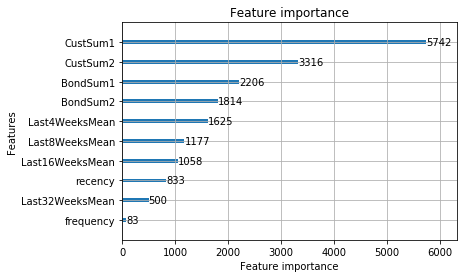

In [159]:
ax = lgb.plot_importance(gbm)
plt.show()

In [160]:
# export CSV
subm = test[["PredictionIdx", "CustomerInterest"]]
subm.to_csv("../submissions/lgb_4lags_RF_cust_bond.csv", index = False, float_format = "%.8f")